# Tarea 2

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import time
from sklearn.decomposition import PCA
import kagglehub
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
import warnings

c:\Users\alvar\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parte 1 Fish-market

### 1. Si aplica, pre procesar datos (manejar valores nulos, comprobar tipo de datos, etc). 

In [2]:
# Download the latest version
path = kagglehub.dataset_download("vipullrathod/fish-market")

# Specify the file name (e.g., 'Fish.csv') if known; list files to check
dataset_file = os.path.join(path, "Fish.csv")  # Replace 'Fish.csv' with the actual file name if different

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(dataset_file)

# Print the first few rows of the DataFrame to confirm
print("DataFrame head:")
print(df.head())

100%|██████████| 2.38k/2.38k [00:00<00:00, 2.44MB/s]

Extracting files...
DataFrame head:
  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340


In [3]:
missing_values = df.isnull().sum()
missing_values

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

No hay valores, nulos.

In [4]:
numOfDuplicatedRows = df.duplicated().sum()
numOfDuplicatedRows

np.int64(0)

### 2.  Realizar gráfico de correlación y pairplot. ¿Qué conclusiones relevantes puede sacar de estos datos? HINT puede usar seaborn para el grafico de pairplot y un heatmap para correlación

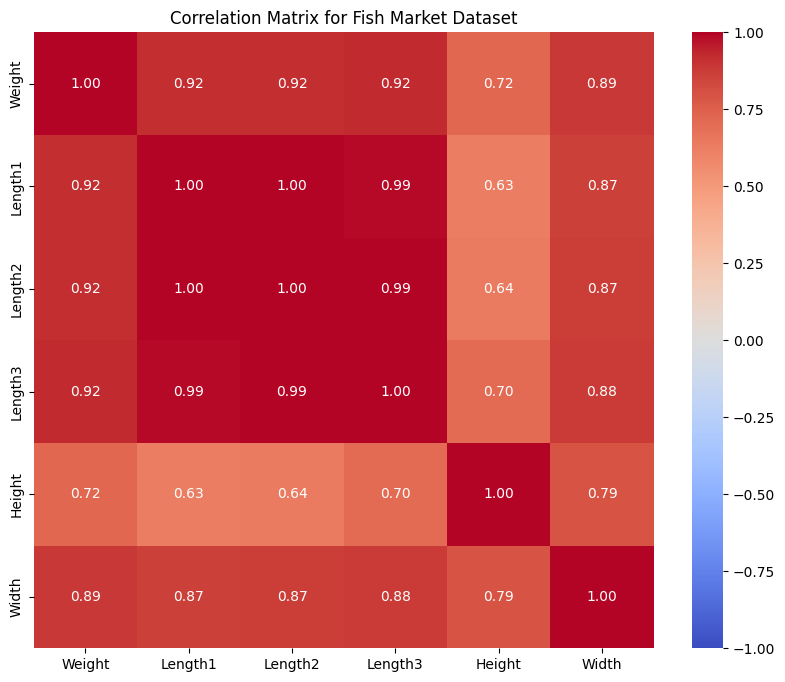

In [5]:
# Calculate the correlation matrix for numerical columns
correlation_matrix = df.drop(columns=['Species']).corr()  # Exclude 'Species' as it is categorical

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Display the heatmap
plt.title("Correlation Matrix for Fish Market Dataset")
plt.show()

La matriz de correlacion demuestra alta correlacion, en las medidas lo cual es trivial ya que son 3 distintas mediciones y deberian ser similares si el sistema de medicion es adecuado.

La variable objetivo tiene mayor correlacion con el largo del pescado,luego ancho y por ultimo altura.

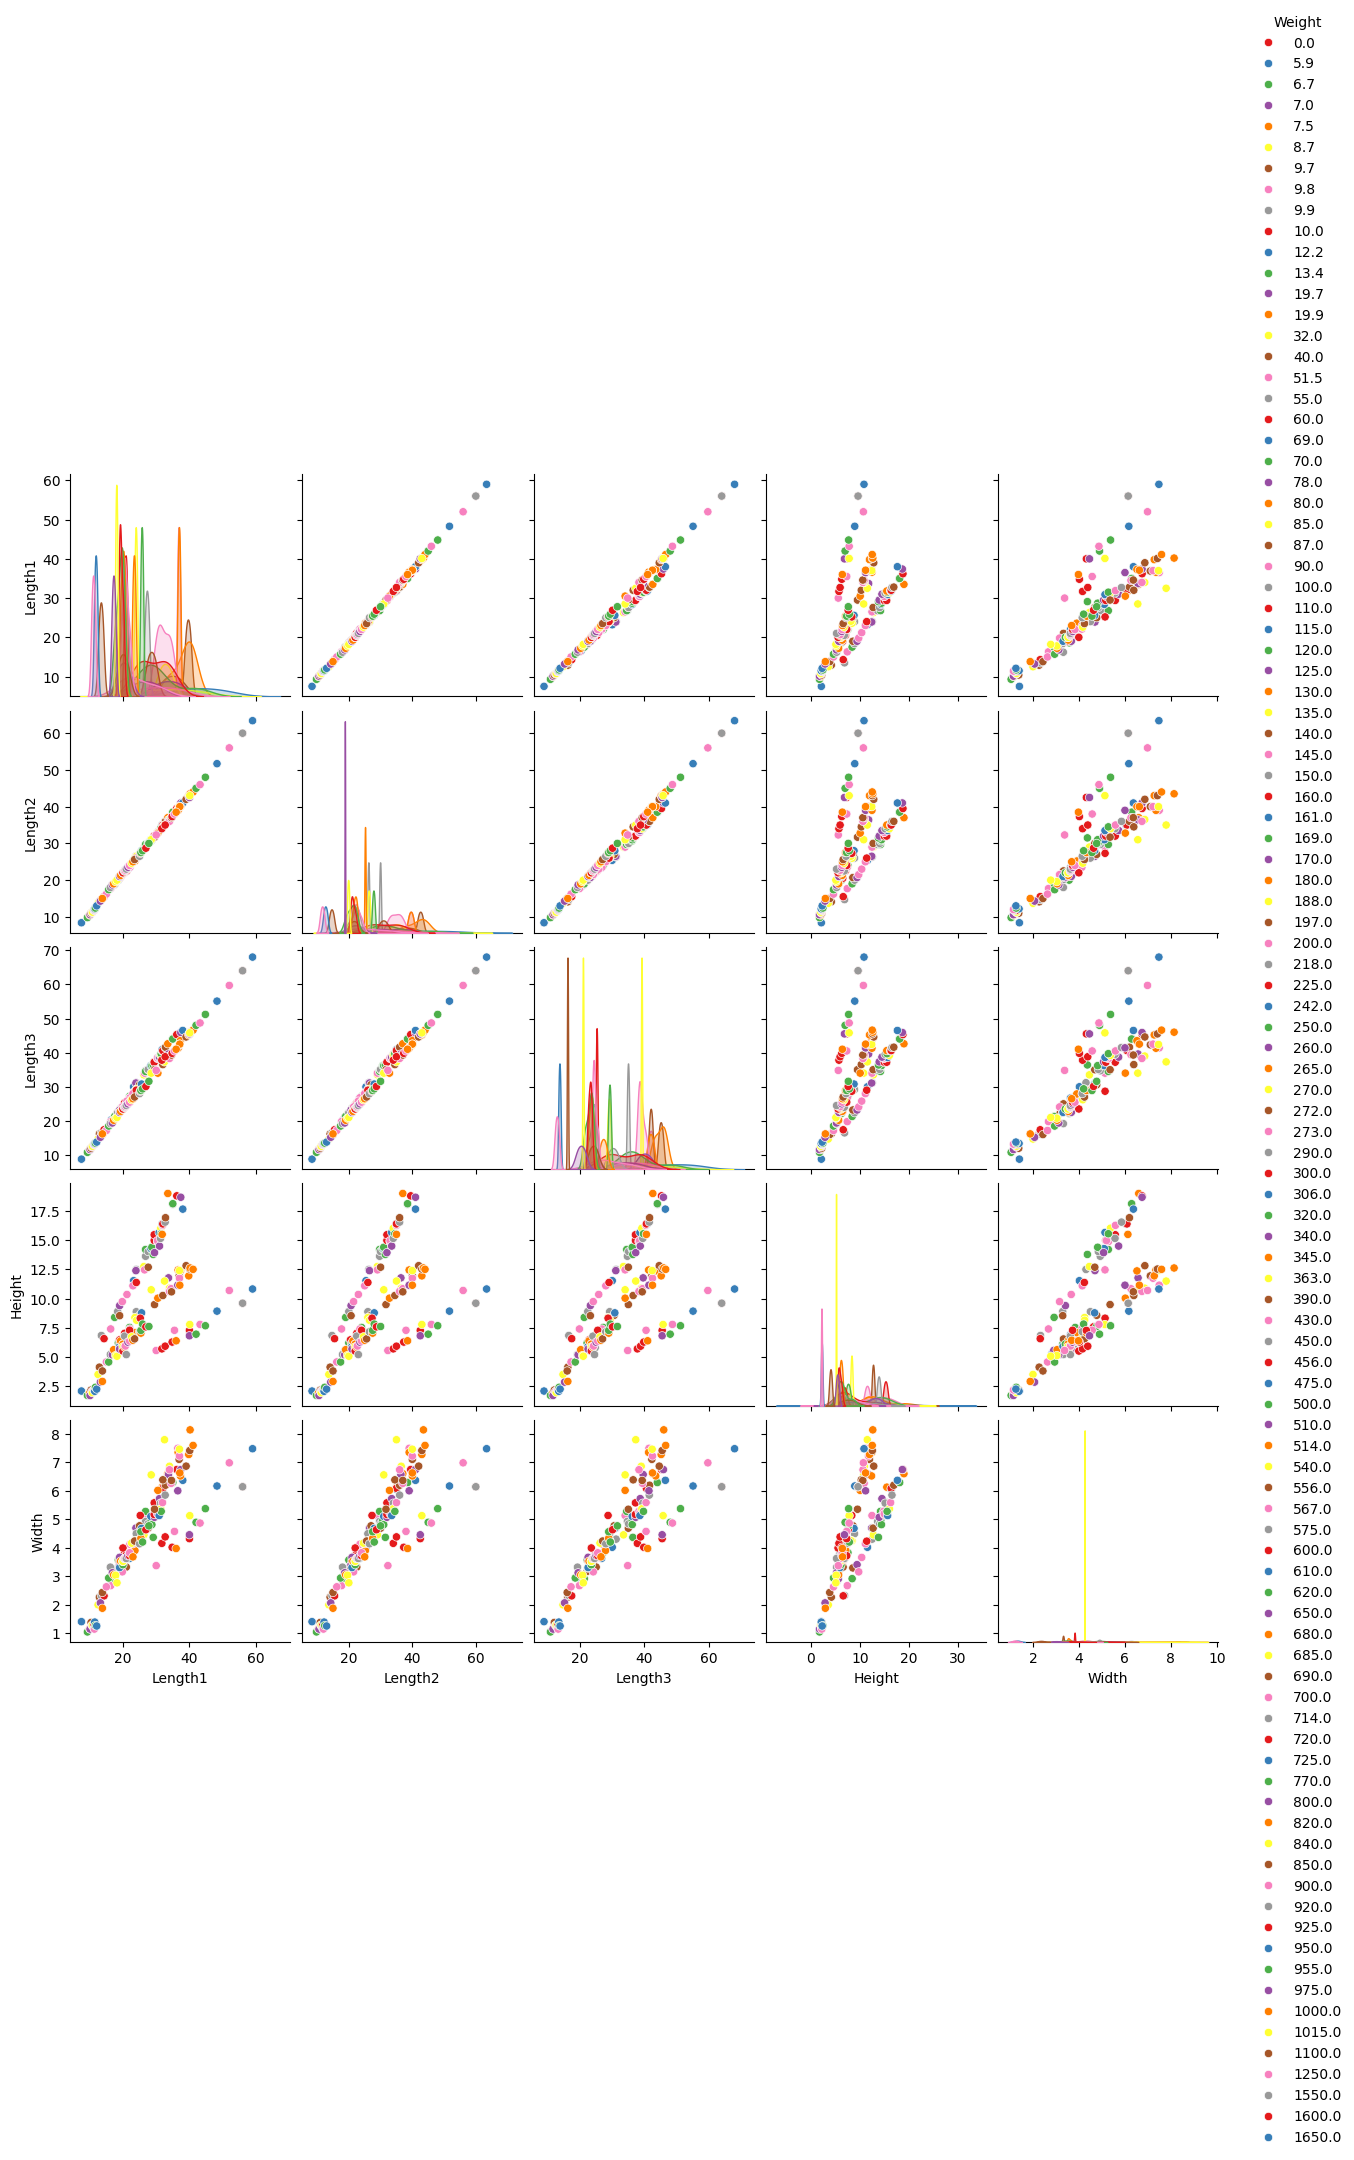

In [6]:
cols = ['Length1', 'Length2', 'Length3', 'Height', 'Width', 'Weight']

sns.pairplot(df[cols], hue='Weight', palette='Set1', diag_kind='kde')

plt.show()

El grafico hace notar relaciones lineales, distribuciones gaussiannas con distintos grados de skewness, poca cantidad de outliers considerando que la mayoria de los datos viven en la misma en el mismo orden de magnitud. el peso varia de 10^0 a 10^3 gramos, el resto de datos varia en torno a 10^1.

Debido a las distribuciones con mucho skewness y pocos outliers eligiremos estandarizar respecto a eso. La otra variable categorica que deberia ser considerada es 'Species', La biologia de la especie puede ser determinante  la hora de predecir el peso.

### 3. Separar datos en train test y val. Luego estandarizar

In [7]:
# Separate features (X) and target variable (y)
X = df.drop(columns=['Weight'])  # Drop only the target 'Weight'
y = df['Weight']  # Target variable

# Define the categorical columns and numeric columns
categorical_features = ['Species']
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create a preprocessor with MinMaxScaler for numeric and OneHotEncoder for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Split data into training+validation (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Split training+validation into training (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

# Apply transformations to the training, validation, and test sets
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# Convert transformed numpy arrays back to DataFrames to make them more readable
# Get column names from numeric and categorical features
cat_columns = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
all_column_names = numeric_features + list(cat_columns)

# Create DataFrames for transformed data
X_train_df = pd.DataFrame(X_train, columns=all_column_names)
X_val_df = pd.DataFrame(X_val, columns=all_column_names)
X_test_df = pd.DataFrame(X_test, columns=all_column_names)

# Print the shapes and first 10 rows of the DataFrames
print("X_train shape:", X_train_df.shape)
print("X_val shape:", X_val_df.shape)
print("X_test shape:", X_test_df.shape)

# Print the first 10 rows of the transformed data for better inspection
print("\nFirst 10 rows of X_train:")
print(X_train_df.head(10))

# Print the target variables for training, validation, and test sets
print("\nFirst 10 values of y_train:")
print(y_train.head(10))

# Resumen estadístico de y_train
mean_y_train = y_train.mean()
max_y_train = y_train.max()
min_y_train = y_train.min()
std_y_train = y_train.std()
median_y_train = y_train.median()

# Mostrar las métricas
print("\nEstadísticas de y_train:")
print(f"Promedio de y_train: {mean_y_train:.2f}")
print(f"Máximo de y_train: {max_y_train:.2f}")
print(f"Mínimo de y_train: {min_y_train:.2f}")
print(f"Desviación estándar de y_train: {std_y_train:.2f}")
print(f"Mediana de y_train: {median_y_train:.2f}")

X_train shape: (107, 12)
X_val shape: (20, 12)
X_test shape: (32, 12)

First 10 rows of X_train:
    Length1   Length2   Length3    Height     Width  Species_Bream  \
0  0.242718  0.247273  0.248311  0.211272  0.428234            0.0   
1  0.427184  0.423636  0.442568  0.447473  0.632828            0.0   
2  0.242718  0.247273  0.248311  0.246292  0.357529            0.0   
3  0.300971  0.301818  0.324324  0.543026  0.450649            0.0   
4  0.145631  0.141818  0.141892  0.155830  0.223128            0.0   
5  0.572816  0.574545  0.569257  0.581295  0.914146            0.0   
6  0.574757  0.574545  0.569257  0.545827  0.824636            0.0   
7  0.281553  0.272727  0.302365  0.294295  0.373505            0.0   
8  0.223301  0.223636  0.243243  0.390999  0.322838            0.0   
9  0.223301  0.220000  0.236486  0.268062  0.331443            0.0   

   Species_Parkki  Species_Perch  Species_Pike  Species_Roach  Species_Smelt  \
0             0.0            1.0           0.0      

### 4. Entrenar modelos Regresion Lineal, Ridge, KRidge y Lasso. teniendo en cuenta las siguientes consideraciones, y respondiendo para cada modelo

In [8]:
# Suprimir ConvergenceWarnings para evitar exceso de mensajes de advertencia
warnings.filterwarnings("ignore", category=UserWarning)

# Eliminar columnas de especies en X_train, X_val y X_test (directamente con numpy arrays)
#columns_to_remove = [5, 6, 7, 8, 9, 10, 11]  # Índices de las columnas que se deben eliminar

# Asegúrate de que las columnas a eliminar existen en los arrays antes de intentar eliminarlas
#X_train = np.delete(X_train, columns_to_remove, axis=1)
#X_val = np.delete(X_val, columns_to_remove, axis=1)
#X_test = np.delete(X_test, columns_to_remove, axis=1)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)

# Preparar listas para almacenar resultados para comparación
models = {}
mse_scores = {}
r2_scores = {}

# Función auxiliar para evaluar el rendimiento del modelo
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mse_scores[model_name] = mse
    r2_scores[model_name] = r2
    return model

################### RESULTADOS DE REGRESIÓN LINEAL ##################

linear_model = LinearRegression()
models['Regresión Lineal'] = evaluate_model(linear_model, X_train, X_val, y_train, y_val, 'Regresión Lineal')

print("\n##### Resultados de la Regresión Lineal #####")
print(f"Regresión Lineal: MSE = {mse_scores['Regresión Lineal']:.4f}, R2 Score = {r2_scores['Regresión Lineal']:.4f}")

################ ALPHA MUY ALTO (1000) ##################

ridge_model_high_alpha = Ridge(alpha=1000)
models['Regresión Ridge (alpha=1000)'] = evaluate_model(ridge_model_high_alpha, X_train, X_val, y_train, y_val, 'Regresión Ridge (alpha=1000)')

lasso_model_high_alpha = Lasso(alpha=1000, max_iter=10000)  # Se aumentaron las iteraciones para manejar la convergencia
models['Regresión Lasso (alpha=1000)'] = evaluate_model(lasso_model_high_alpha, X_train, X_val, y_train, y_val, 'Regresión Lasso (alpha=1000)')

k_ridge_model_high_alpha = KernelRidge(alpha=1000, kernel='rbf')
models['Regresión Kernel Ridge (alpha=1000)'] = evaluate_model(k_ridge_model_high_alpha, X_train, X_val, y_train, y_val, 'Regresión Kernel Ridge (alpha=1000)')

print("\n##### Resultados para Alpha Muy Alto (1000) #####")
for model_name in ['Regresión Ridge (alpha=1000)', 'Regresión Lasso (alpha=1000)', 'Regresión Kernel Ridge (alpha=1000)']:
    print(f"{model_name}: MSE = {mse_scores[model_name]:.4f}, R2 Score = {r2_scores[model_name]:.4f}")

################ ALPHA MUY BAJO (0.0001) ##################

ridge_model_low_alpha = Ridge(alpha=0.0001)
models['Regresión Ridge (alpha=0.0001)'] = evaluate_model(ridge_model_low_alpha, X_train, X_val, y_train, y_val, 'Regresión Ridge (alpha=0.0001)')

lasso_model_low_alpha = Lasso(alpha=0.0001, max_iter=10000)  # Se aumentaron las iteraciones para manejar la convergencia
models['Regresión Lasso (alpha=0.0001)'] = evaluate_model(lasso_model_low_alpha, X_train, X_val, y_train, y_val, 'Regresión Lasso (alpha=0.0001)')

k_ridge_model_low_alpha = KernelRidge(alpha=0.0001, kernel='rbf')
models['Regresión Kernel Ridge (alpha=0.0001)'] = evaluate_model(k_ridge_model_low_alpha, X_train, X_val, y_train, y_val, 'Regresión Kernel Ridge (alpha=0.0001)')

print("\n##### Resultados para Alpha Muy Bajo (0.0001) #####")
for model_name in ['Regresión Ridge (alpha=0.0001)', 'Regresión Lasso (alpha=0.0001)', 'Regresión Kernel Ridge (alpha=0.0001)']:
    print(f"{model_name}: MSE = {mse_scores[model_name]:.4f}, R2 Score = {r2_scores[model_name]:.4f}")

Shape of X_train: (107, 12)
Shape of X_val: (20, 12)

##### Resultados de la Regresión Lineal #####
Regresión Lineal: MSE = 4648.1036, R2 Score = 0.9268

##### Resultados para Alpha Muy Alto (1000) #####
Regresión Ridge (alpha=1000): MSE = 70157.5557, R2 Score = -0.1043
Regresión Lasso (alpha=1000): MSE = 74463.4994, R2 Score = -0.1721
Regresión Kernel Ridge (alpha=1000): MSE = 133433.6693, R2 Score = -1.1003

##### Resultados para Alpha Muy Bajo (0.0001) #####
Regresión Ridge (alpha=0.0001): MSE = 4493.4841, R2 Score = 0.9293
Regresión Lasso (alpha=0.0001): MSE = 4621.7279, R2 Score = 0.9273
Regresión Kernel Ridge (alpha=0.0001): MSE = 943.1354, R2 Score = 0.9852


### 4.a. ¿Qué pasa con las predicciones cuando el valor del nivel de regularización (alpha) es muy alto en Lasso y Ridge?

  Cuando el valor de alpha tiende a valores muy alto, ocurren distintas cosas para Ridge y Lasso

  En Ridge los valores de los coeficientes asociados a las predicciones, solo tienden a 0, pero no desaparecen, asi que si bien se aplica una penalización muy alta, la naturaleza de este metodo aún mantiene los coeficientes, haciendo posible construir un modelo que obtenga si bien no resultados buenos, un modelo consistente.

  Para Lasso, cuando se tienen alpha muy altos, y por ende penalizaciónes muy altas, los coeficientes pueden efectivamente volverse 0, lo que lo hace un método mas "drástico" en el sentido de que un valor de alpha muy cercano a 0 puede destruir completamente el modelo, borando el impacto de todas las variables asociadas a los coeficientes del modelo.

  Los valores obtenidos desmuestran lo anteriormente mencionado, existiendo un R^2 de 0.5 para alphas muy grande en RIDGE, y un R^2 de -0.17 En Lasso que no tiene mucho sentido, pues seguramente no hay coeficientes que orienten las predicciones.


### 4.b ¿Qué pasa con las predicciones cuando el valor de alpha tiende a cero en Lasso y Ridge? ¿A qué modelo de regresión se asemeja y por qué?

Cuando el valor de alpha tiende a 0, la penalización de ridge y lasso disminuye y los coeficientes generados para la predicción no cambian mucho.

En este caso ambos modelos se comportan de manera similar, por lo que, al teneder a 0 es como si esta penalización aplicada por ambos metodos no existiera ya que afecta muy poco el modelo final, lo que ocasiona que los modelos finalmente se comporten como un lineal regression común.

### 4.c Luego de elegir un valor de alpha óptimo para Lasso, Ridge y KRidge, realizar entrenamiento. HINT: pruebe distintos Kernel para KRidge.

(El ajuste de alpha óptimo se hace en el conjunto de validación para disminuir la probabilidad de un overfitting de los datos)

In [9]:
# Función auxiliar para evaluar el rendimiento del modelo
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name, mse_scores, r2_scores, mae_scores, training_times):
    start_time = time.time()  # Iniciar la medición del tiempo de entrenamiento
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Calculamos el MSE, R² y MAE
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    # Almacenamos los resultados en los diccionarios correspondientes
    mse_scores[model_name] = mse
    r2_scores[model_name] = r2
    mae_scores[model_name] = mae

    end_time = time.time()  # Fin de la medición
    training_time = end_time - start_time  # Calculamos el tiempo de entrenamiento
    training_times[model_name] = training_time  # Guardamos el tiempo de entrenamiento

    return model

def buscar_mejor_alpha(modelo, X_train, X_val, y_train, y_val, alphas, nombre_modelo, search_times):
    start_time = time.time()  # Iniciar la medición del tiempo de búsqueda de alpha
    best_alpha = None
    best_mse = float('inf')  # Inicializamos con el valor más alto posible para minimizar el MSE
    for alpha in alphas:
        modelo.set_params(alpha=alpha)  # Ajustar el valor de alpha del modelo
        modelo.fit(X_train, y_train)
        mse = mean_squared_error(y_val, modelo.predict(X_val))  # Usamos MSE en lugar de R²
        if mse < best_mse:  # Elegimos el alpha que minimiza el MSE
            best_mse = mse
            best_alpha = alpha
    end_time = time.time()  # Fin de la medición
    search_time = end_time - start_time  # Calculamos el tiempo de búsqueda del alpha

    # Impresión adicional para depuración
    print(f"Tiempo de búsqueda alpha {nombre_modelo}: {search_time:.4f} segundos")

    search_times[nombre_modelo] = search_time  # Guardamos el tiempo de búsqueda

    return best_alpha, best_mse

# Inicialización de contenedores
mse_scores = {}  # Diccionario para MSE
r2_scores = {}   # Diccionario para R²
mae_scores = {}  # Diccionario para MAE
training_times = {}  # Diccionario para el tiempo de entrenamiento
search_times = {}  # Diccionario para el tiempo de búsqueda de alpha
alphas = np.logspace(-4, 3, 50)  # Valores de alpha de 1e-4 a 1e3

# Buscar el mejor alpha para cada modelo
print("\n##### Búsqueda de Alpha Óptimo #####")
ridge_model = Ridge()
best_alpha_ridge, best_mse_ridge = buscar_mejor_alpha(ridge_model, X_train, X_val, y_train, y_val, alphas, 'Ridge', search_times)

lasso_model = Lasso(max_iter=10000)
best_alpha_lasso, best_mse_lasso = buscar_mejor_alpha(lasso_model, X_train, X_val, y_train, y_val, alphas, 'Lasso', search_times)

kernel_ridge_model_linear = KernelRidge(kernel='linear')
best_alpha_kr_linear, best_mse_kr_linear = buscar_mejor_alpha(kernel_ridge_model_linear, X_train, X_val, y_train, y_val, alphas, 'Kernel Ridge (Linear)', search_times)

kernel_ridge_model_rbf = KernelRidge(kernel='rbf')
best_alpha_kr_rbf, best_mse_kr_rbf = buscar_mejor_alpha(kernel_ridge_model_rbf, X_train, X_val, y_train, y_val, alphas, 'Kernel Ridge (RBF)', search_times)

kernel_ridge_model_poly = KernelRidge(kernel='poly')
best_alpha_kr_poly, best_mse_kr_poly = buscar_mejor_alpha(kernel_ridge_model_poly, X_train, X_val, y_train, y_val, alphas, 'Kernel Ridge (Poly)', search_times)

# Añadir el modelo LinearRegression
linear_model = LinearRegression()
# No es necesario buscar el alpha ya que LinearRegression no utiliza regularización L2 ni un parámetro alpha
best_alpha_linear = None  # No aplica para LinearRegression
best_mse_linear = mean_squared_error(y_val, linear_model.fit(X_train, y_train).predict(X_val))

# Mostrar los resultados de alpha óptimo para cada modelo
print(f"\nRidge - Alpha Óptimo: {best_alpha_ridge:.2f}")
print(f"Lasso - Alpha Óptimo: {best_alpha_lasso:.2f}")
print(f"Kernel Ridge (Linear) - Alpha Óptimo: {best_alpha_kr_linear:.2f}")
print(f"Kernel Ridge (RBF) - Alpha Óptimo: {best_alpha_kr_rbf:.2f}")
print(f"Kernel Ridge (Poly) - Alpha Óptimo: {best_alpha_kr_poly:.2f}")

# Evaluar cada modelo con el alpha óptimo
models = {
    'Ridge (Alpha Óptimo)': Ridge(alpha=best_alpha_ridge),
    'Lasso (Alpha Óptimo)': Lasso(alpha=best_alpha_lasso, max_iter=10000),
    'Kernel Ridge (Linear, Alpha Óptimo)': KernelRidge(alpha=best_alpha_kr_linear, kernel='linear'),
    'Kernel Ridge (RBF, Alpha Óptimo)': KernelRidge(alpha=best_alpha_kr_rbf, kernel='rbf'),
    'Kernel Ridge (Poly, Alpha Óptimo)': KernelRidge(alpha=best_alpha_kr_poly, kernel='poly'),
    'Linear Regression': linear_model  # Modelo Linear Regression sin necesidad de alpha
}

# Evaluación de los modelos
for model_name, model in models.items():
    models[model_name] = evaluate_model(model, X_train, X_val, y_train, y_val, model_name, mse_scores, r2_scores, mae_scores, training_times)

# Mostrar los resultados con el MSE, R², MAE, Tiempo de Entrenamiento y Tiempo de Búsqueda de Alpha
print("\n##### Resultados con Alpha Óptimo, MSE, R², MAE, Tiempo de Entrenamiento y Tiempo de Búsqueda #####")
for model_name in models.keys():
    total_time = training_times[model_name] + search_times.get(model_name, 0)  # Tiempo total
    print(f"{model_name}: MSE = {mse_scores[model_name]:.4f}, R² = {r2_scores[model_name]:.4f}, MAE = {mae_scores[model_name]:.4f}, Tiempo de Entrenamiento = {training_times[model_name]:.4f} segundos")


##### Búsqueda de Alpha Óptimo #####
Tiempo de búsqueda alpha Ridge: 0.0631 segundos
Tiempo de búsqueda alpha Lasso: 0.2959 segundos
Tiempo de búsqueda alpha Kernel Ridge (Linear): 0.0602 segundos
Tiempo de búsqueda alpha Kernel Ridge (RBF): 0.0837 segundos
Tiempo de búsqueda alpha Kernel Ridge (Poly): 0.0872 segundos

Ridge - Alpha Óptimo: 0.37
Lasso - Alpha Óptimo: 1.00
Kernel Ridge (Linear) - Alpha Óptimo: 0.10
Kernel Ridge (RBF) - Alpha Óptimo: 0.01
Kernel Ridge (Poly) - Alpha Óptimo: 0.01

##### Resultados con Alpha Óptimo, MSE, R², MAE, Tiempo de Entrenamiento y Tiempo de Búsqueda #####
Ridge (Alpha Óptimo): MSE = 3107.2715, R² = 0.9511, MAE = 44.7904, Tiempo de Entrenamiento = 0.0020 segundos
Lasso (Alpha Óptimo): MSE = 3337.5858, R² = 0.9475, MAE = 45.7124, Tiempo de Entrenamiento = 0.0020 segundos
Kernel Ridge (Linear, Alpha Óptimo): MSE = 3350.6646, R² = 0.9473, MAE = 45.6838, Tiempo de Entrenamiento = 0.0020 segundos
Kernel Ridge (RBF, Alpha Óptimo): MSE = 426.1863, R² = 0.

### 4.d Entrenar una regresión lineal mediante Forward Stepwise Selection y Backward Stepwise Selection para elegir los atributos mas relevantes.

In [10]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Función de evaluación para el modelo
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return mse, r2

# Configurar el modelo Linear Regression
linear_model = LinearRegression()

# Forward Stepwise Selection (Selección hacia adelante)
sfs_forward = SFS(linear_model,
                  k_features='best',  # Selecciona el mejor número de características
                  forward=True,  # Forward Stepwise
                  floating=False,  # Sin Floating (sin retroceso)
                  scoring='neg_mean_squared_error',  # MSE como métrica
                  cv=5)  # Validación cruzada con 5 pliegues

# Medir el tiempo de ejecución del modelo Forward Stepwise
start_time_forward = time.time()

# Aplicar Forward Stepwise Selection
sfs_forward = sfs_forward.fit(X_train, y_train)

# Medir el tiempo de ejecución
end_time_forward = time.time()
time_forward = end_time_forward - start_time_forward  # Tiempo total de ejecución

# Características seleccionadas (convertir a índices enteros)
selected_features_forward = list(sfs_forward.k_feature_idx_)
print(f"Forward Stepwise Selection - Índice de las características que quedaron: {selected_features_forward}")

# Obtener los nombres de las características desde los DataFrames
feature_names = X_train_df.columns

# Características eliminadas (usando los índices)
removed_features_forward = [feature_names[i] for i in range(len(feature_names)) if i not in selected_features_forward]

# Mostrar los nombres de las características seleccionadas y eliminadas
print(f"Características seleccionadas: {', '.join(feature_names[selected_features_forward])}")
print(f"Características eliminadas: {', '.join(removed_features_forward)}")

# Evaluar el modelo con las características seleccionadas
mse_forward, r2_forward = evaluate_model(linear_model, X_train[:, selected_features_forward], y_train, X_val[:, selected_features_forward], y_val)
print(f"MSE con Forward Stepwise Selection: {mse_forward:.4f}")
print(f"R² con Forward Stepwise Selection: {r2_forward:.4f}")
print(f"Tiempo de entrenamiento (Forward Stepwise): {time_forward:.4f} segundos")

#------------------------------------------------------------------------------------------------------------------------------------------
print("")

# Backward Stepwise Selection (Selección hacia atrás)
sfs_backward = SFS(linear_model,
                   k_features='best',  # Selecciona el mejor número de características
                   forward=False,  # Backward Stepwise
                   floating=False,  # Sin Floating
                   scoring='neg_mean_squared_error',  # MSE como métrica
                   cv=5)  # Validación cruzada con 5 pliegues

# Medir el tiempo de ejecución del modelo Backward Stepwise
start_time_backward = time.time()

# Aplicar Backward Stepwise Selection
sfs_backward = sfs_backward.fit(X_train, y_train)

# Medir el tiempo de ejecución
end_time_backward = time.time()
time_backward = end_time_backward - start_time_backward  # Tiempo total de ejecución

# Características seleccionadas (convertir a índices enteros)
selected_features_backward = list(sfs_backward.k_feature_idx_)
print(f"Backward Stepwise Selection - Índice de las características que quedaron: {selected_features_backward}")

# Características eliminadas (usando los índices)
removed_features_backward = [feature_names[i] for i in range(len(feature_names)) if i not in selected_features_backward]

# Mostrar los nombres de las características seleccionadas y eliminadas
print(f"Características seleccionadas: {', '.join(feature_names[selected_features_backward])}")
print(f"Características eliminadas: {', '.join(removed_features_backward)}")

# Evaluar el modelo con las características seleccionadas
mse_backward, r2_backward = evaluate_model(linear_model, X_train[:, selected_features_backward], y_train, X_val[:, selected_features_backward], y_val)
print(f"MSE con Backward Stepwise Selection: {mse_backward:.4f}")
print(f"R² con Backward Stepwise Selection: {r2_backward:.4f}")
print(f"Tiempo de entrenamiento (Backward Stepwise): {time_backward:.4f} segundos")


Forward Stepwise Selection - Índice de las características que quedaron: [0, 1, 2, 6, 8, 10]
Características seleccionadas: Length1, Length2, Length3, Species_Parkki, Species_Pike, Species_Smelt
Características eliminadas: Height, Width, Species_Bream, Species_Perch, Species_Roach, Species_Whitefish
MSE con Forward Stepwise Selection: 4087.1420
R² con Forward Stepwise Selection: 0.9357
Tiempo de entrenamiento (Forward Stepwise): 0.6312 segundos

Backward Stepwise Selection - Índice de las características que quedaron: [1, 5, 6, 7, 9, 10, 11]
Características seleccionadas: Length2, Species_Bream, Species_Parkki, Species_Perch, Species_Roach, Species_Smelt, Species_Whitefish
Características eliminadas: Length1, Length3, Height, Width, Species_Pike
MSE con Backward Stepwise Selection: 3525.8661
R² con Backward Stepwise Selection: 0.9445
Tiempo de entrenamiento (Backward Stepwise): 0.6070 segundos


### 4.e Proponer 2 métricas de evaluación final relevantes y evaluar.

In [11]:
# Evaluación de los modelos con el conjunto de prueba (X_test, y_test)
models_test = {
    'Ridge (Alpha Óptimo)': Ridge(alpha=best_alpha_ridge),
    'Lasso (Alpha Óptimo)': Lasso(alpha=best_alpha_lasso, max_iter=10000),
    'Kernel Ridge (Linear, Alpha Óptimo)': KernelRidge(alpha=best_alpha_kr_linear, kernel='linear'),
    'Kernel Ridge (RBF, Alpha Óptimo)': KernelRidge(alpha=best_alpha_kr_rbf, kernel='rbf'),
    'Kernel Ridge (Poly, Alpha Óptimo)': KernelRidge(alpha=best_alpha_kr_poly, kernel='poly'),
    'Forward Stepwise Selection': linear_model,
    'Backward Stepwise Selection': linear_model,
    'Linear Regression': linear_model  # Agregado Linear Regression
}

# Realizar predicciones y calcular MSE y R² en X_test y y_test
mse_test = {}
r2_test = {}
selected_features_forward_names = []  # Para almacenar los nombres de características seleccionadas en Forward
selected_features_backward_names = []  # Para almacenar los nombres de características seleccionadas en Backward

for model_name, model in models_test.items():
    if model_name == 'Forward Stepwise Selection':
        model.fit(X_train[:, selected_features_forward], y_train)  # Asegurarse de usar las características seleccionadas
        y_pred = model.predict(X_test[:, selected_features_forward])
        # Guardar los nombres de las características seleccionadas en Forward
        selected_features_forward_names = [X_train_df.columns[i] for i in selected_features_forward]
    elif model_name == 'Backward Stepwise Selection':
        model.fit(X_train[:, selected_features_backward], y_train)  # Asegurarse de usar las características seleccionadas
        y_pred = model.predict(X_test[:, selected_features_backward])
        # Guardar los nombres de las características seleccionadas en Backward
        selected_features_backward_names = [X_train_df.columns[i] for i in selected_features_backward]
    else:
        model.fit(X_train, y_train)  # Entrenamos los demás modelos con todo el conjunto de entrenamiento
        y_pred = model.predict(X_test)

    mse_test[model_name] = mean_squared_error(y_test, y_pred)
    r2_test[model_name] = r2_score(y_test, y_pred)

# Mostrar las métricas MSE y R² para cada modelo
print("\n##### Resultados en el conjunto de prueba (X_test, y_test) #####")
for model_name in models_test.keys():
    print(f"{model_name}: MSE = {mse_test[model_name]:.4f}, R² = {r2_test[model_name]:.4f}")



##### Resultados en el conjunto de prueba (X_test, y_test) #####
Ridge (Alpha Óptimo): MSE = 6981.3276, R² = 0.9509
Lasso (Alpha Óptimo): MSE = 7525.6564, R² = 0.9471
Kernel Ridge (Linear, Alpha Óptimo): MSE = 7428.5224, R² = 0.9478
Kernel Ridge (RBF, Alpha Óptimo): MSE = 3033.2489, R² = 0.9787
Kernel Ridge (Poly, Alpha Óptimo): MSE = 2844.8467, R² = 0.9800
Forward Stepwise Selection: MSE = 5746.5063, R² = 0.9596
Backward Stepwise Selection: MSE = 6896.8145, R² = 0.9515
Linear Regression: MSE = 6669.4064, R² = 0.9531


### 4.f Revisar que atributos fueron seleccionado por cada modelo. ¿Existe alguna semejanza entre las columnas seleccionas por los distintos modelos?


In [12]:
# Mostrar las características seleccionadas para los modelos de selección de características
print("\n##### Atributos seleccionados por los modelos de selección de características #####")
if selected_features_forward_names:
    print(f"Forward Stepwise Selection - Atributos seleccionados: {', '.join(selected_features_forward_names)}")
if selected_features_backward_names:
    print(f"Backward Stepwise Selection - Atributos seleccionados: {', '.join(selected_features_backward_names)}")


##### Atributos seleccionados por los modelos de selección de características #####
Forward Stepwise Selection - Atributos seleccionados: Length1, Length2, Length3, Species_Parkki, Species_Pike, Species_Smelt
Backward Stepwise Selection - Atributos seleccionados: Length2, Species_Bream, Species_Parkki, Species_Perch, Species_Roach, Species_Smelt, Species_Whitefish


Se pueden hacer algunas inferencias en cuanto a los atributos seleccionados por forward stepwise y backward stepwise:

Lenght2 y Species_Parkki, Species_Pike, Species_Smelt estan en ambos modelos; en cuanto a lenght2, debe ser un atrbuto con una alta influecia en el peso del pez, en cuanto a las catergorias, es probable que se asocien a un coeficiente del modelo que también influye mucho en el peso, es por ello que aquellos peces que categorizados como tal, probablemente tengan un coeficiente asociado que facilita la predicción de peso.

Por otro lado Lenght2 y Lenght3 son solamente escogidos por Forwards Stepwise, Por ello creemos que es probable que Backward stepwise haya identificado más certeramente la correlación entre todos los atributos de Lenght, y es por ello que los elimino, haciendo un modelo más "general" y menos complejo, lo cual también es esperable, pues este último también consume más recursos a costa de hacer una busqueda más exausthiva y detectar mejor esas correlaciones, pues parte con todos los atributos.

### 4.g Guardar tiempos de entrenamiento y métricas de cada modelo para compararlos mas adelante.

| Modelo                    | Tiempo ejecución [s] | MSE        | R²      |
|---------------------------|----------------------|------------|---------|
| Ridge                     | 0,0884               | 6981.3276  | 0.9509  |
| Lasso                     | 0,4264               | 7525.6564  | 0.9471  |
| Kernel Ridge (lineal)     | 0,1055               | 7428.5224  | 0.9478  |
| Kernel Ridge (RBF)        | 0,1278               | 3033.2489  | 0.9787  |
| Kernel Ridge (polinomial) | 0,1174               | 2844.8467  | 0.9800  |
| Forward Stepwise Selection | 0,9720               | 5746.5063  | 0.9596  |
| Backward Stepwise Selection| 1,109               | 7128.7000  | 0.9499  |
| Linear Regression          | 0,0044              | 6669.4064  | 0.9531  |

### 5. Diga por qué las escogió dichas métricas. Además para cada dataset responda ¿Cuál modelo se adapta mejor en tiempo y rendimiento?


- $R^2$ ya que es una métrica precisa para cuantificar que porcentaje de los datos se explican por la recta / hiperplano creado por el modelo para realizar las predicciones, o en otras palabras, la comparación entre la varianza de los errores (relacionados a la recta) y la varianza total de los datos. Por lo tanto es un métrica útil en contextos donde los datos se preveen tendrán un ajuste lineal. En este caso los peces con medidas mas grandes evidentemente tendrán mayor peso.

- MSE, Si bien, se calcula también MSA, MSE en este contexto es extremadamente útil, pues el principal problema que se tiene en el dataset, es que hay distintas categorias de peces que fueron agregador al dataset como variables extras en columnas adicionales, y esto provoca que en ocaciones los modelos otorguen pesos muy alejados al real, ya que si bien el modelo no categoriza, si se puede inferir que en algunos casos el peso predicho esta muy alejado del real probablemente por que los coeficientes del modelo asociado a la categoria del pez no están bien calibrados. Por ello creemos que la penalización del MSE es adecuada en este contexto, ya que un bajo valor de MSE representa que cada vez el modelo reconoce con mayor exactitud el peso y su relación al tipo de pez.


En cuanto a rendimiento, quiene ocupa menor recursos computacionales es el modelo de regresión lineal puro, lo que es esperable, pues no útiliza componentes adicionales que haga un mayor uso de recursos y por ende de tiempo de ejecución.

Por otro lado el método más costoso es Backward stepwise, lo cual es esperable, pues a través de un algoritmo greedy va en busca de cada vez mejores soluciones iniciando con todos los atributos del modelo, lo que lo hace iterar muchas veces, gastando recursos hasta encontrar una solución óptima. Aún asi este metodo obtuvo el peor resultado, lo cual no se esperaba, ya que el dataset parecia bastante complejo, y atribuimos este comportamiento a la poca cantidad de filas del dataset.

El con mejor rendimiento en cuanto a métricas tanto para $R^2$ y $MSE$ es Kernel Ridge (polinomial), obteniendo respectivamente valores de 2844.8467 y	0.9800, lo cual es un resultado que no esperabamos inicialmente, pues los datos parecien tener una relación lineal bastante simple de acuerdo a los gráficos, sin embargo este modelo lograr capturar interacciones mas complejas de los datos, que creemos es debido a la presencia de diversos tipos de peces, que dificultan en gran medida la capacidad de los demás modelos en "generalizar".


### 6. Para cada dataset, según su conocimiento teórico ¿Cuál modelo debió adaptarse mejor en rendimiento? ¿por qué? ¿concuerda con lo obtenido?

Según el conocimiento teórico y considerando el tipo de datos en el dataset, un modelo de regresión lineal (como el modelo Linear Regression) y todos aquellos derivados, esperabamos se adaptaran bien. En este caso, si los peces con medidas más grandes tienden a tener un mayor peso, la relación entre las características (como la medida de los peces) debería haber sido lineal.

Los resultados demuestran que cuando hay más atributos, captar las interacciones entre atributos a través de graficos se vuelve una tarea más compleja y no se puede confiar totalmente de la información que se ve, al tratar además con mas dimensiones, hacer una visualización general no es posible. Por lo tanto en base a ello, si se concuerda con lo obtenido, y creemos que el hecho de que Kernel Ridge polimial sea el mejor modelo, es reflejo de que a medida que se trabaja con datasets más complejos, las relaciones entre variables se vuelven menos intuitivas, y es necesario probar empiricamente diversos modelos y encontrar aquel que otorge mejores resultados.

## Parte 1 Concrete Data

### 1. Si aplica, pre procesar datos (manejar valores nulos, comprobar tipo de datos, etc). 

In [13]:

file = 'Concrete_Data_Yeh.csv'
data = pd.read_csv(file)
data.head()



,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [14]:
valores_nulos = data.isnull().sum()
data_types = data.dtypes

valores_nulos, data_types

(cement              0
 slag                0
 flyash              0
 water               0
 superplasticizer    0
 coarseaggregate     0
 fineaggregate       0
 age                 0
 csMPa               0
 dtype: int64,
 cement              float64
 slag                float64
 flyash              float64
 water               float64
 superplasticizer    float64
 coarseaggregate     float64
 fineaggregate       float64
 age                   int64
 csMPa               float64
 dtype: object)

### 2.  Realizar gráfico de correlación y pairplot. ¿Qué conclusiones relevantes puede sacar de estos datos? HINT puede usar seaborn para el grafico de pairplot y un heatmap para correlación

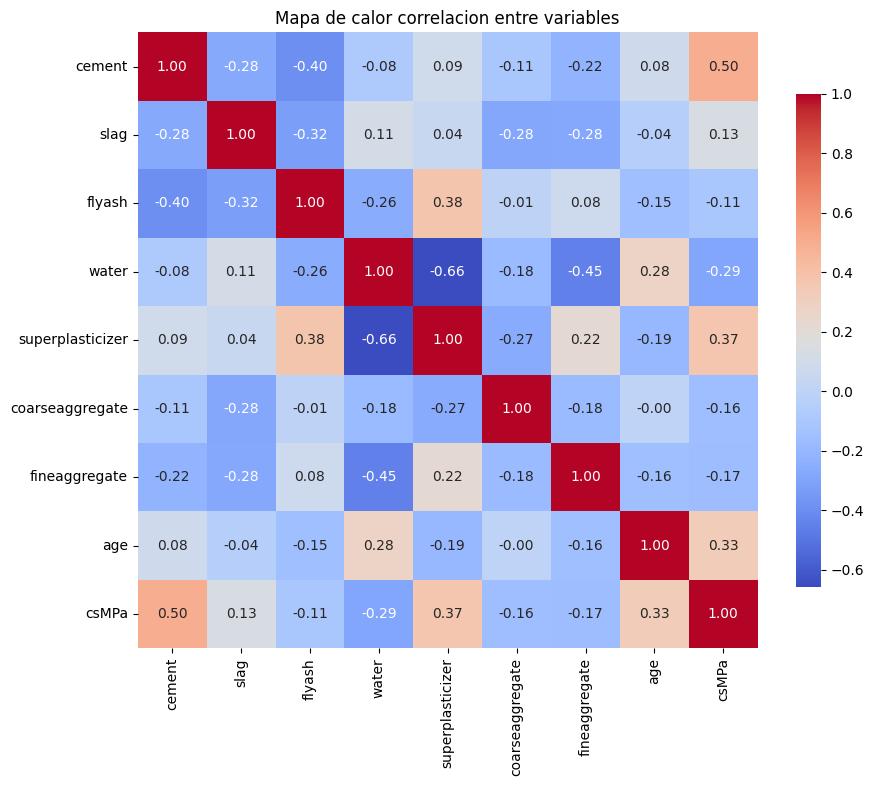

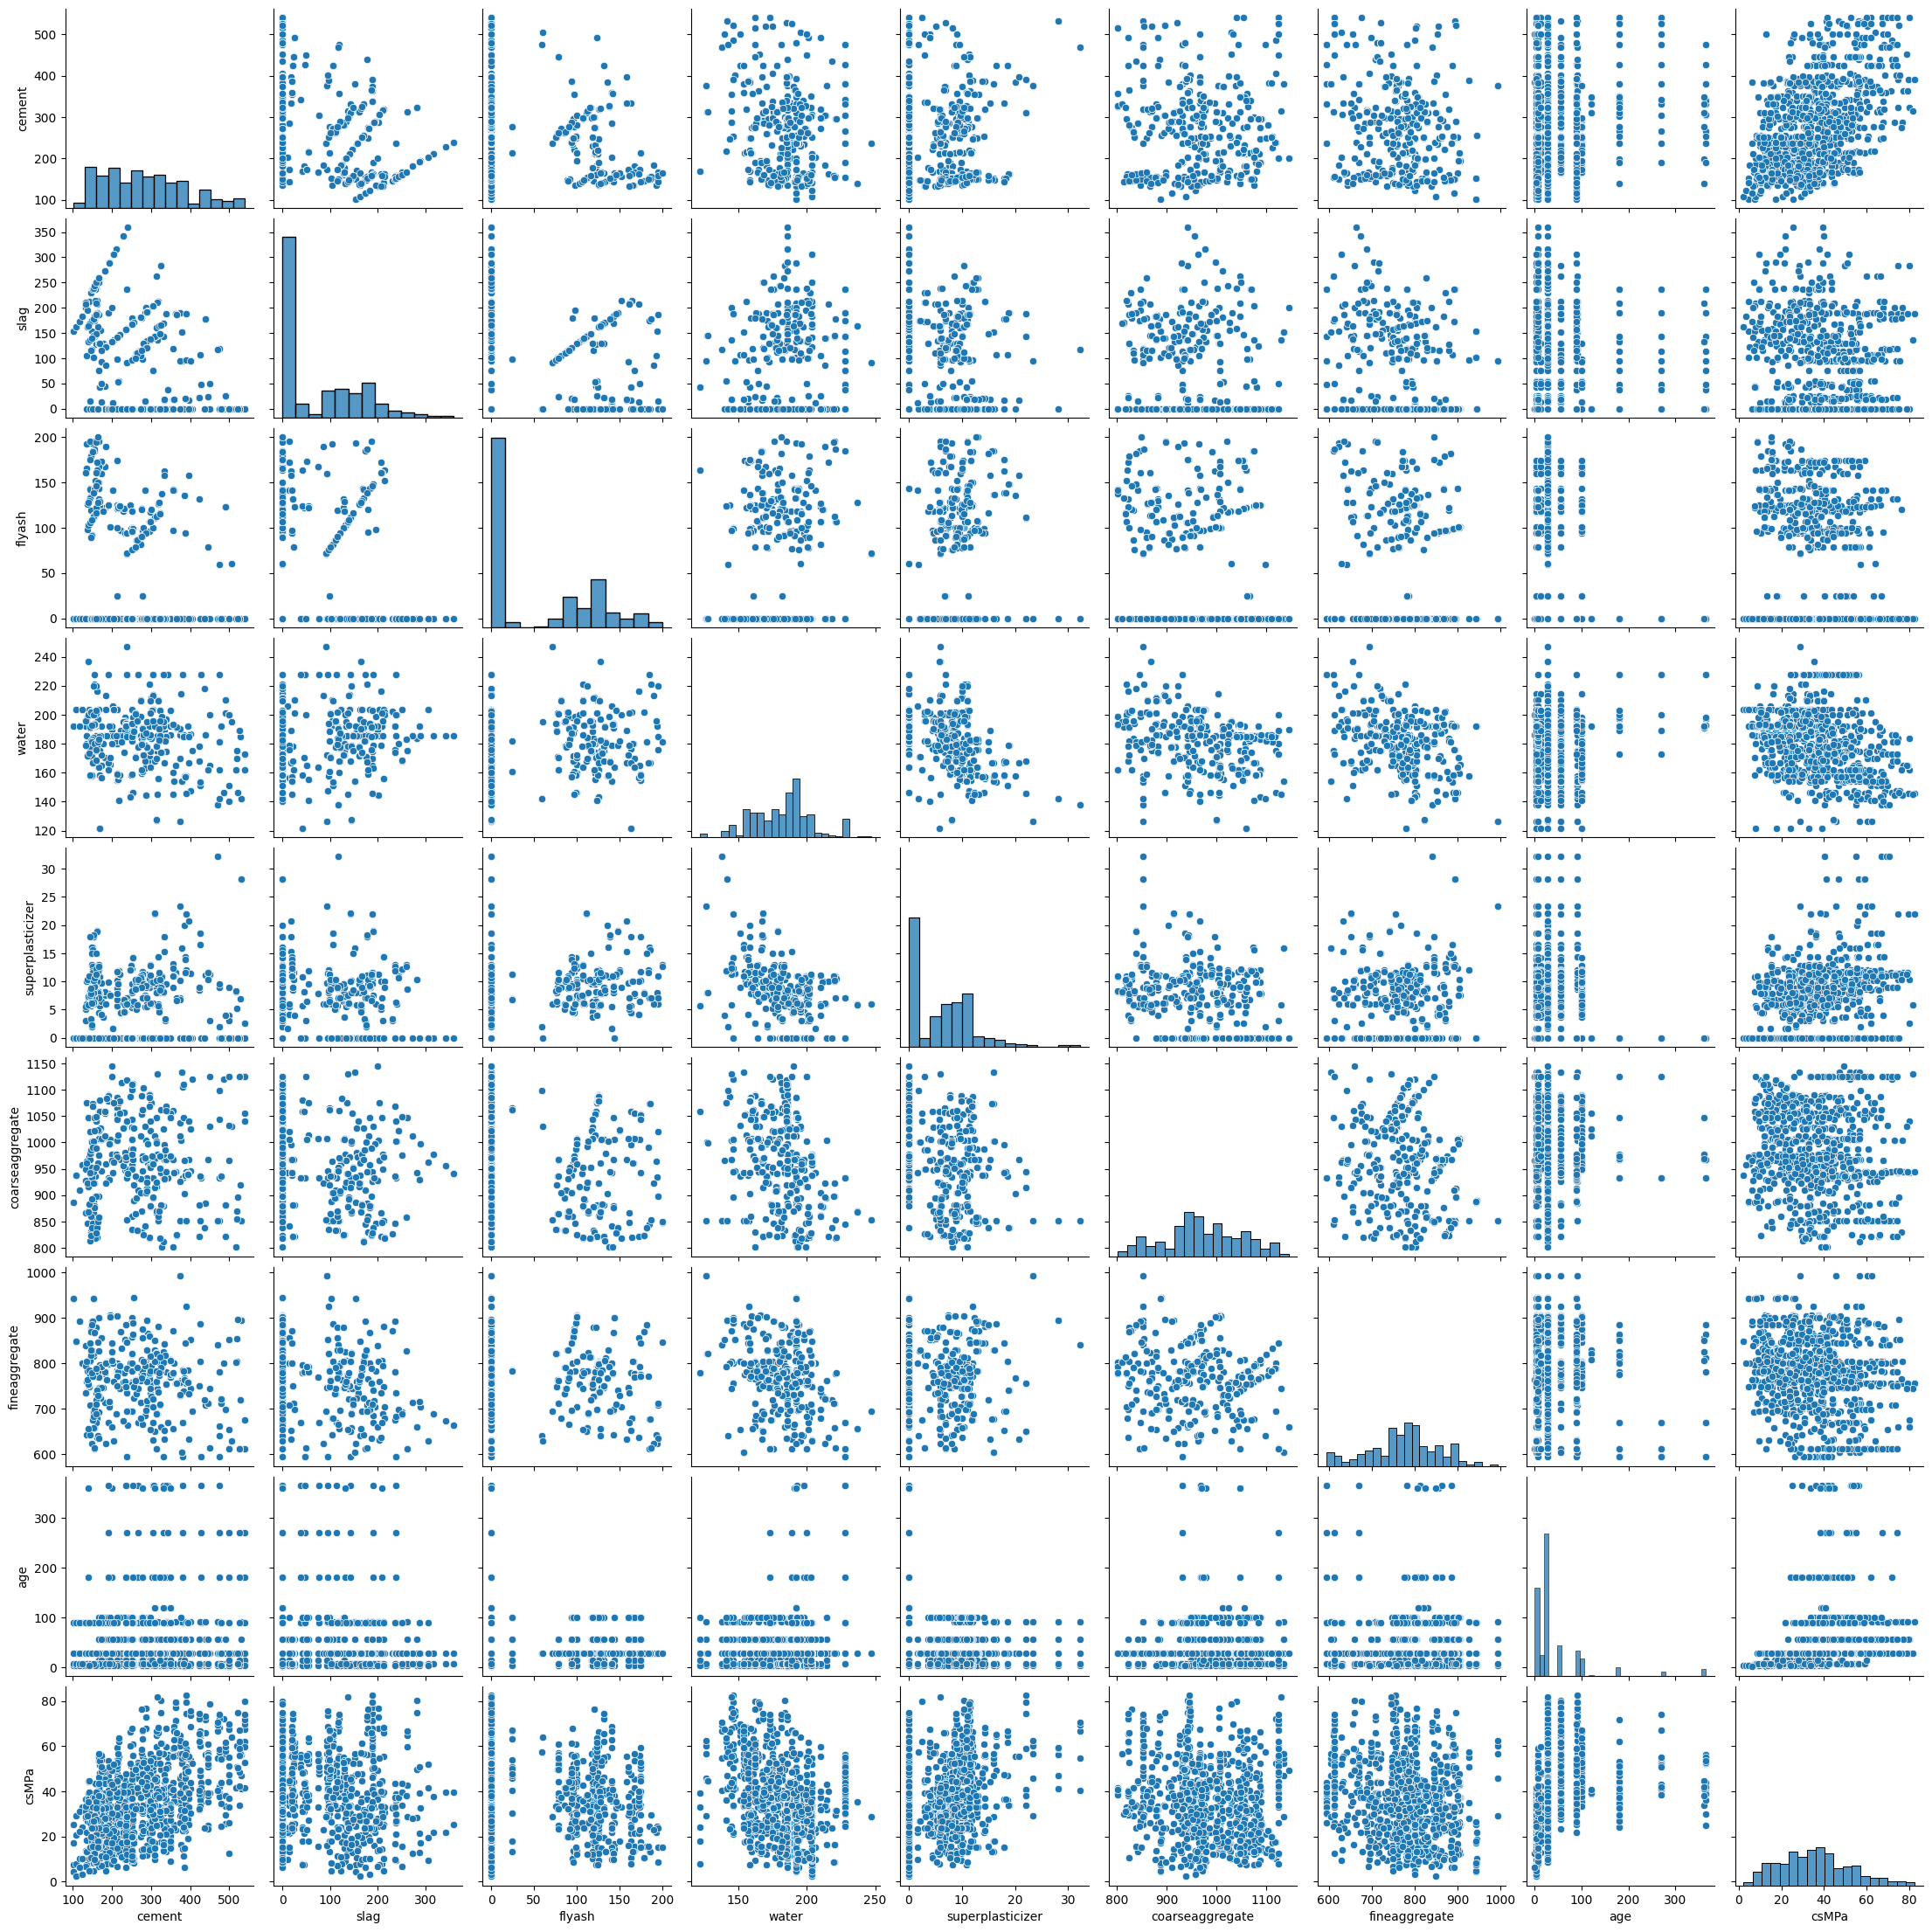

In [15]:


# Set up the matplotlib figure for heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'shrink': .8})
plt.title("Mapa de calor correlacion entre variables")
plt.show()

# Pairplot for visualizing relationships
sns.pairplot(data)
plt.show()

Para el mapa de calor se puede observar una correlación moderada de la resistencia a compresión (csMPa) con variables como cement y age, mientras que la variable water tiene una correlación negativa. Esto sugiere que a mayor cantidad de cemento y edad, el concreto tiende a ser más resistente, mientras que cantidades altas de agua podrían debilitarlo.

Para el pairplot las distribuciones de las variables presentan cierta dispersión y linealidad en casos específicos, como cement y csMPa.

### 3. Separar datos en train test y val. Luego estandarizar

In [16]:
X = data.drop(columns=['csMPa'])
y = data['csMPa']


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)

((618, 8), (206, 8), (206, 8))

### 4. Entrenamiento de modelos.

In [17]:
# Regresion Lineal
model = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento escalados
model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de validación
y_val_pred_LR = model.predict(X_val_scaled)

# Evaluar el modelo en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred_LR)
r2_val = r2_score(y_val, y_val_pred_LR)


In [18]:
#Ridge
alpha = 1.0
ridge = Ridge(alpha=alpha)
ridge.fit(X_train_scaled, y_train)  # Entrenar el modelo
    
# Predicciones en el conjunto de validación
y_val_pred_ridge = ridge.predict(X_val_scaled)
    
# Cálculo de métricas
mse_val_ridge = mean_squared_error(y_val, y_val_pred_ridge)
r2_val_ridge = r2_score(y_val, y_val_pred_ridge)

In [19]:
#kridge
kridge_model = KernelRidge(alpha=0.0, kernel='rbf')  # Puedes probar otros kernels, como 'linear' o 'polynomial'
kridge_model.fit(X_train_scaled, y_train)  # Entrenar el modelo

# Predicciones y evaluación en el conjunto de validación para Kernel Ridge
y_val_pred_kridge = kridge_model.predict(X_val_scaled)
mse_val_kridge = mean_squared_error(y_val, y_val_pred_kridge)
r2_val_kridge = r2_score(y_val, y_val_pred_kridge)

In [20]:
#Lasso
alpha = 1.0
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train_scaled, y_train)  # Entrenar el modelo
    
# Predicciones en el conjunto de validación
y_val_pred_lasso = lasso_model.predict(X_val_scaled)
    
# Cálculo de métricas
mse_val_lasso = mean_squared_error(y_val, y_val_pred_lasso)
r2_val_lasso = r2_score(y_val, y_val_pred_lasso)

4.a) ¿Qué pasa con las predicciones cuando el valor del nivel de
regularización (alpha) es muy alto en Lasso y Ridge?

R: Para valores altos de alpha como 50 y 100 las predicciones de Lasso y Ridge tienden a perder calidad en base a las metricas propuestas en este análisis, si nos fijamos en los valores para el MSE podremos notar incrementos para ambos modelos, lo que nos da señales de underfitting en las predicciones. Por otro lado si nos fijamos en los valores de R2 en el caso de Ridge notamos que a medida que aumenta el alpha el valor de R2 también lo hace, sin embargo este cambio no es tan drástico como el presente en Lasso, el cual llega a tener valores negativos en R2, de esto podemos decir que la capacidad predictiva del modelo se ve muy mermada en casos de R2 negativo, por lo que asumimos que estos valores de alpha no son los adecuados.

4.b) ¿Qué pasa con las predicciones cuando el valor de alpha tiende a cero
en Lasso y Ridge? ¿A qué modelo de regresión se asemeja y por qué?

R: Si se ajusta alpha a un valor cercano a 0, las predicciones exhiben comportamientos contrarios a los vistos en la pregunta anterior, ya que ambos modelos podrían presentar overfitting debido a que no se está aplicando regulación, por ende los resultados de las metricas MSE y R2 se asemejan mucho a los de una regresión lineal ordinaria, esto debido a que al no haber penalización estos modelos siempre van a minimizar el error de predicción sin imponer restricciones en los coeficientes.

4.c Luego de elegir un valor de alpha óptimo para Lasso, Ridge y KRidge,
realizar entrenamiento. HINT: pruebe distintos Kernel para KRidge.


In [21]:
# Definir los valores de alpha a probar
alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Alpha óptimo para Ridge
ridge_grid = GridSearchCV(Ridge(), param_grid={'alpha': alpha_values}, scoring='neg_mean_squared_error', cv=5)
ridge_grid.fit(X_train_scaled, y_train)
print("Mejor alpha para Ridge:", ridge_grid.best_params_)
print("Mejor MSE para Ridge:", -ridge_grid.best_score_)

# Alpha óptimo para Lasso
lasso_grid = GridSearchCV(Lasso(), param_grid={'alpha': alpha_values}, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train_scaled, y_train)
print("Mejor alpha para Lasso:", lasso_grid.best_params_)
print("Mejor MSE para Lasso:", -lasso_grid.best_score_)


Mejor alpha para Ridge: {'alpha': 0.1}
Mejor MSE para Ridge: 108.48683823220237
Mejor alpha para Lasso: {'alpha': 0.001}
Mejor MSE para Lasso: 108.48963740775889


In [22]:
param_grid = {
    "alpha": [0.1, 1, 10, 50, 100, 500, 1000],
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}
warnings.filterwarnings("ignore", category=UserWarning)
grid_search = GridSearchCV(KernelRidge(), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_scaled, y_train)

# Imprimir los mejores parámetros y el score
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor MSE (validación cruzada):", -grid_search.best_score_)


Mejores parámetros: {'alpha': 0.1, 'kernel': 'rbf'}
Mejor MSE (validación cruzada): 41.73529377744501


Entrenamiento de modelos con alpha y kernel optimos.

In [23]:
#Ridge
alpha = 0.1
ridge = Ridge(alpha=alpha)
ridge.fit(X_train_scaled, y_train)  # Entrenar el modelo
    
# Predicciones en el conjunto de validación
y_val_pred_ridge = ridge.predict(X_val_scaled)
    
# Cálculo de métricas
mse_val_ridge = mean_squared_error(y_val, y_val_pred_ridge)
r2_val_ridge = r2_score(y_val, y_val_pred_ridge)

In [24]:
#Lasso
alpha = 0.001
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train_scaled, y_train)  # Entrenar el modelo
    
# Predicciones en el conjunto de validación
y_val_pred_lasso = lasso_model.predict(X_val_scaled)
    
# Cálculo de métricas
mse_val_lasso = mean_squared_error(y_val, y_val_pred_lasso)
r2_val_lasso = r2_score(y_val, y_val_pred_lasso)

In [25]:
#Kridge
kridge_model = KernelRidge(alpha=0.1, kernel='rbf')  # Puedes probar otros kernels, como 'linear' o 'polynomial'
kridge_model.fit(X_train_scaled, y_train)  # Entrenar el modelo

# Predicciones y evaluación en el conjunto de validación para Kernel Ridge
y_val_pred_kridge = kridge_model.predict(X_val_scaled)
mse_val_kridge = mean_squared_error(y_val, y_val_pred_kridge)
r2_val_kridge = r2_score(y_val, y_val_pred_kridge)

In [26]:
param_grid = {
    "alpha": [0.1, 1, 10, 50, 100, 500, 1000],
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}
warnings.filterwarnings("ignore", category=UserWarning)
grid_search = GridSearchCV(KernelRidge(), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_scaled, y_train)

# Imprimir los mejores parámetros y el score
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor MSE (validación cruzada):", -grid_search.best_score_)


Mejores parámetros: {'alpha': 0.1, 'kernel': 'rbf'}
Mejor MSE (validación cruzada): 41.73529377744501


4d Entrenar una regresión lineal mediante Forward Stepwise Selection y
Backward Stepwise Selection para elegir los atributos mas relevantes.

In [27]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

# Forward Stepwise Selection
sfs_forward = SFS(model,
                  k_features="best",  # Número de características a seleccionar
                  forward=True,       # Activar selección hacia adelante
                  floating=False,     # Modo estricto, no "floating"
                  scoring='neg_mean_squared_error',  # Métrica a optimizar (MSE negativo)
                  cv=5)               # Cross-validation de 5 pliegues

sfs_forward = sfs_forward.fit(X_train, y_train)

# Obtener nombres de las características seleccionadas para forward
selected_features_forward = X_train.columns[list(sfs_forward.k_feature_idx_)]
X_train_selected_forward = X_train[selected_features_forward]
X_test_selected_forward = X_test[selected_features_forward]

# Entrenar el modelo con las características seleccionadas
model.fit(X_train_selected_forward, y_train)

# Realizar predicciones
y_pred_forward = model.predict(X_test_selected_forward)

# Calcular MSE y R2 en el conjunto de prueba
mse_forward = mean_squared_error(y_test, y_pred_forward)
r2_forward = r2_score(y_test, y_pred_forward)

# Imprimir resultados
print("Características seleccionadas (Forward):", sfs_forward.k_feature_names_)
print("Mejor puntaje (MSE negativo):", sfs_forward.k_score_)
print("MSE en test (Forward):", mse_forward)
print("R² en test (Forward):", r2_forward)


# Backward Stepwise Selection
sfs_backward = SFS(model,
                   k_features="best",  # Número de características a seleccionar
                   forward=False,      # Activar selección hacia atrás
                   floating=False,     # Modo estricto, no "floating"
                   scoring='neg_mean_squared_error',  # Métrica a optimizar (MSE negativo)
                   cv=5)               # Cross-validation de 5 pliegues

sfs_backward = sfs_backward.fit(X_train, y_train)

# Obtener nombres de las características seleccionadas para backward
selected_features_backward = X_train.columns[list(sfs_backward.k_feature_idx_)]
X_train_selected_backward = X_train[selected_features_backward]
X_test_selected_backward = X_test[selected_features_backward]

# Entrenar el modelo con las características seleccionadas
model.fit(X_train_selected_backward, y_train)

# Realizar predicciones
y_pred_backward = model.predict(X_test_selected_backward)

# Calcular MSE y R2 en el conjunto de prueba
mse_backward = mean_squared_error(y_test, y_pred_backward)
r2_backward = r2_score(y_test, y_pred_backward)

# Imprimir resultados
print("Características seleccionadas (Backward):", sfs_backward.k_feature_names_)
print("Mejor puntaje (MSE negativo):", sfs_backward.k_score_)
print("MSE en test (Backward):", mse_backward)
print("R² en test (Backward):", r2_backward)


Características seleccionadas (Forward): ('cement', 'slag', 'flyash', 'water', 'fineaggregate', 'age')
Mejor puntaje (MSE negativo): -114.45339095587501
MSE en test (Forward): 96.41198036039678
R² en test (Forward): 0.6258415773031096
Características seleccionadas (Backward): ('cement', 'slag', 'flyash', 'water', 'fineaggregate', 'age')
Mejor puntaje (MSE negativo): -114.45339095587501
MSE en test (Backward): 96.41198036039678
R² en test (Backward): 0.6258415773031096


4e Proponer 2 métricas de evaluación final relevantes y evaluar.

R: En nuestro caso las dos métricas relevantes siguen siendo MSE y R2, para el caso de las stepwise selection   

4f) evisar que atributos fueron seleccionado por cada modelo. ¿Existe
alguna semejanza entre las columnas seleccionas por los distintos
modelos?

R: Los atributos seleccionados por cada modelo fueron, 'cement', 'slag', 'flyash', 'water', 'fineaggregate', 'age'. En nuestro caso ambos modelos escogieron exactamente los mismos atributos.

4g)  Guardar tiempos de entrenamiento y métricas de cada modelo para
compararlos mas adelante.

In [28]:
results = []



X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado después de la división
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)



# Modelo LR
start_time = time.time()
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_val_pred_LR = model.predict(X_val_scaled)
time_LR = time.time() - start_time
mse_val = mean_squared_error(y_val, y_val_pred_LR)
r2_val = r2_score(y_val, y_val_pred_LR)
results.append(["Linear Regression", time_LR, mse_val, r2_val])

# Modelo Ridge
alpha = 0.1
start_time = time.time()
ridge = Ridge(alpha=alpha)
ridge.fit(X_train_scaled, y_train)
y_val_pred_ridge = ridge.predict(X_val_scaled)
time_ridge = time.time() - start_time
mse_val_ridge = mean_squared_error(y_val, y_val_pred_ridge)
r2_val_ridge = r2_score(y_val, y_val_pred_ridge)
results.append(["Ridge", time_ridge, mse_val_ridge, r2_val_ridge])

# Modelo Lasso
alpha = 0.001
start_time = time.time()
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train_scaled, y_train)
y_val_pred_lasso = lasso_model.predict(X_val_scaled)
time_lasso = time.time() - start_time
mse_val_lasso = mean_squared_error(y_val, y_val_pred_lasso)
r2_val_lasso = r2_score(y_val, y_val_pred_lasso)
results.append(["Lasso", time_lasso, mse_val_lasso, r2_val_lasso])

# Modelo Kernel Ridge
start_time = time.time()
kridge_model = KernelRidge(alpha=0.1, kernel='rbf')
kridge_model.fit(X_train_scaled, y_train)
y_val_pred_kridge = kridge_model.predict(X_val_scaled)
time_kridge = time.time() - start_time
mse_val_kridge = mean_squared_error(y_val, y_val_pred_kridge)
r2_val_kridge = r2_score(y_val, y_val_pred_kridge)
results.append(["Kernel Ridge", time_kridge, mse_val_kridge, r2_val_kridge])

# Forward Stepwise Selection
start_time = time.time()
sfs_forward = SFS(LinearRegression(), k_features="best", forward=True, floating=False, scoring='neg_mean_squared_error', cv=5)
sfs_forward.fit(X_train, y_train)
X_train_selected_forward = X_train[X_train.columns[list(sfs_forward.k_feature_idx_)]]
X_test_selected_forward = X_test[X_train.columns[list(sfs_forward.k_feature_idx_)]]
model.fit(X_train_selected_forward, y_train)
y_pred_forward = model.predict(X_test_selected_forward)
time_forward = time.time() - start_time
mse_forward = mean_squared_error(y_test, y_pred_forward)
r2_forward = r2_score(y_test, y_pred_forward)
results.append(["Forward Stepwise", time_forward, mse_forward, r2_forward])

# Backward Stepwise Selection
start_time = time.time()
sfs_backward = SFS(LinearRegression(), k_features="best", forward=False, floating=False, scoring='neg_mean_squared_error', cv=5)
sfs_backward.fit(X_train, y_train)
X_train_selected_backward = X_train[X_train.columns[list(sfs_backward.k_feature_idx_)]]
X_test_selected_backward = X_test[X_train.columns[list(sfs_backward.k_feature_idx_)]]
model.fit(X_train_selected_backward, y_train)
y_pred_backward = model.predict(X_test_selected_backward)
time_backward = time.time() - start_time
mse_backward = mean_squared_error(y_test, y_pred_backward)
r2_backward = r2_score(y_test, y_pred_backward)
results.append(["Backward Stepwise", time_backward, mse_backward, r2_backward])



results_df = pd.DataFrame(results, columns=["Model", "Execution Time (s)", "MSE", "R²"])
results_df


,Model,Execution Time (s),MSE,R²
0,Linear Regression,0.002041,95.970940,0.627553
1,Ridge,0.001003,95.969734,0.627558
2,Lasso,0.001968,95.970059,0.627557
3,Kernel Ridge,0.326132,32.025219,0.875716
4,Forward Stepwise,0.335014,96.411980,0.625842
5,Backward Stepwise,0.521850,96.411980,0.625842


### 5.Diga por qué las escogió dichas métricas. Además para cada dataset responda ¿Cuál modelo se adapta mejor en tiempo y rendimiento?

R: Las métricas fueron escogidas debido a que evalúan de manera precisa y efectiva la precisión de los modelos de regresión utilizados en este análisis sobre el dataset de resistencia a la compresión del cemento, esto en términos de error (MSE) y variabilidad capturada (R2)

El modelo que mejor se adaptó  yque tuvo un mejor rendimiento en las métricas de tiempo, MSE y R2 fue Kernel Ridge, este tuvo un valor de 32.03 para MSE y 0.88 en R2, además de que la mayoría de modelos tuvieron tiempos de ejeción similares.

### 6.Para cada dataset, según su conocimiento teórico ¿Cuál modelo debió adaptarse mejor en rendimiento? ¿por qué? ¿concuerda con lo obtenido?

R: Basandonos en carácteristicas del dataset como la multicolinealidad de las variables, y el número de estas creemos que un modelo como Ridge o Kridge tiene la ventaja sobre otros debido a la penalización integrada en función de la multicolinealidad lo que en datasets como el del cemento puede entregar modelos mas robustos y estables. En vista de los resultados exhibidos en preguntas anteriores nuestras predicciones si concuerdan con el resultado final para el modelo que mejor se adaptó, Kernel Ridge.

# Parte 2 Concrete Data

### 1. Si aplica, pre procesar datos (manejar valores nulos, comprobar tipo de datos, etc). 

In [29]:
data.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [30]:
valores_nulos = data.isnull().sum()
data_types = data.dtypes

valores_nulos, data_types

(cement              0
 slag                0
 flyash              0
 water               0
 superplasticizer    0
 coarseaggregate     0
 fineaggregate       0
 age                 0
 csMPa               0
 dtype: int64,
 cement              float64
 slag                float64
 flyash              float64
 water               float64
 superplasticizer    float64
 coarseaggregate     float64
 fineaggregate       float64
 age                   int64
 csMPa               float64
 dtype: object)

### 2. Realizar grafico de correlacion

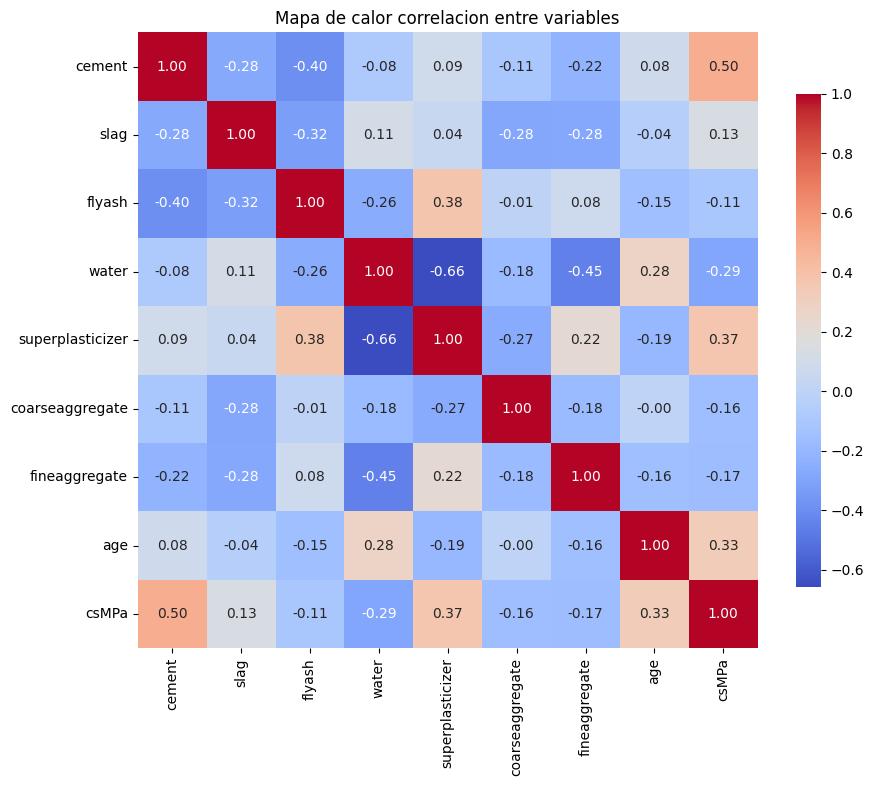

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'shrink': .8})
plt.title("Mapa de calor correlacion entre variables")
plt.show()

### 3. Separar datos en train test y val. Luego estandarizar.

In [32]:
X = data.drop(columns=['csMPa'])
y = data['csMPa']


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)

((618, 8), (206, 8), (206, 8))

### 4. Aplicar PCA al conjunto de train con el numero máximo de dimensiones y realizar grafico de varianza explicada vs nro. dimensiones. ¿Con cuántas dimensiones se puede explicar el dataset sin perder la integridad de este?

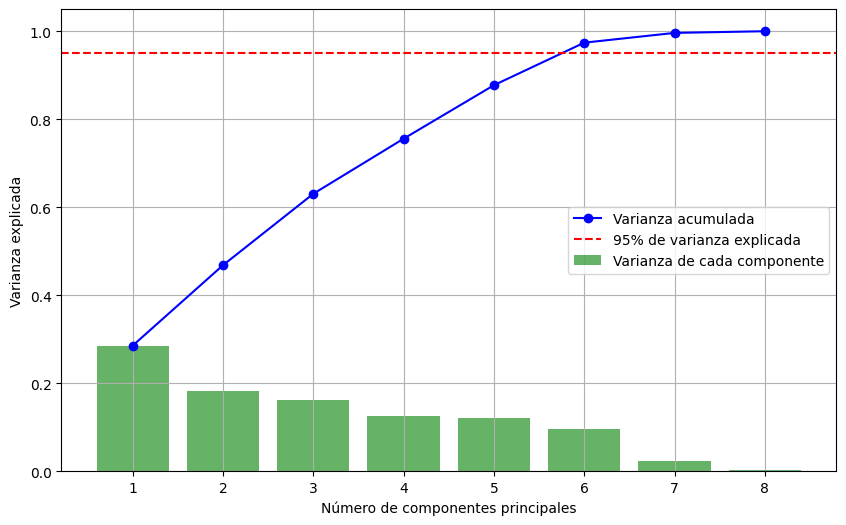

In [33]:
pca = PCA(n_components=X.shape[1])  
pca.fit_transform(X_train_scaled)


explained_variance = pca.explained_variance_ratio_
explained_variance_cumulative = explained_variance.cumsum()


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance_cumulative, marker='o', color='b', label='Varianza acumulada')
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color='g', label='Varianza de cada componente')

plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% de varianza explicada')
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.grid()
plt.show()

Como se ve en el grafico, a partir de las 6 dimensiones se puede explicar mas del 95% del dataset por lo que podemos prescindir de las otras 2 dimensiones, ya que no aportan lo suficiente.

### 5. Aplicar PCA con el numero de dimensiones seleccionado y realizar grafico  de correlación a su resultado. ¿Qué particularidad se observa en el gráfico?

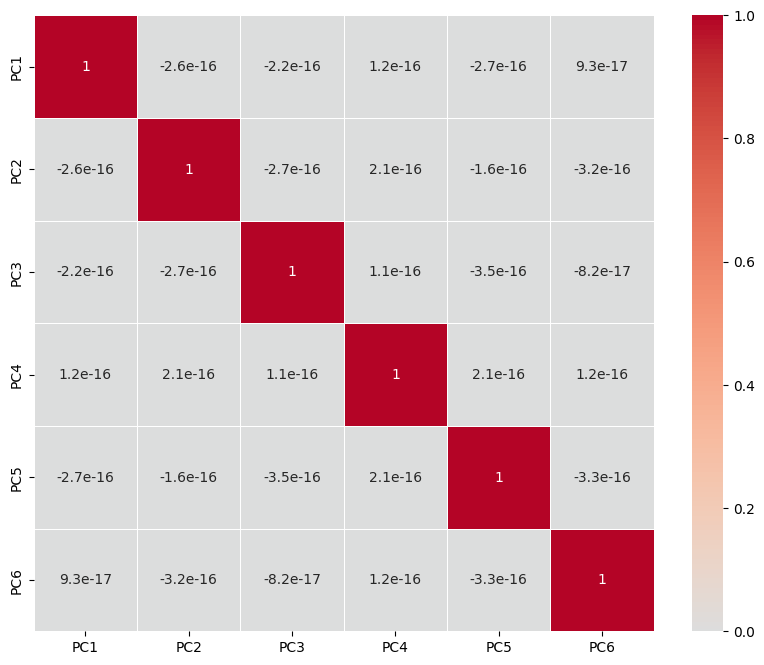

In [34]:
pca = PCA(n_components=6)

x_pca = pca.fit_transform(X_train_scaled)

df_pca = pd.DataFrame(x_pca, columns=[f"PC{i+1}" for i in range(6)])

correlation_matrix = df_pca.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.show()

Se puede ver que no hay correlacion alguna entre componentes, eso quiere decir que todos tienen informacion que aportar y ninguno es redundante. Ademas, PCA en la construccion busca componentes que sean ortogonales por lo que la correlacion debiese ser 0 o cercana a 0 entre ellos.

### 6. Realizar predicción con los modelos vistos en clases realizando ajuste de hiperparámetros para optimizar su modelo (ya sea Cross Validation u otra técnica).

In [35]:
pca = PCA(n_components=6)

x_train_pca = pca.fit_transform(X_train_scaled)
x_val_pca = pca.transform(X_val_scaled)
x_test_pca = pca.transform(X_test_scaled)

x_train_pca.shape, x_val_pca.shape, x_test_pca.shape


((618, 6), (206, 6), (206, 6))

In [36]:
#regresion lineal
LR = LinearRegression()
LR.fit(x_train_pca, y_train)


#lasso
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso = Lasso()
grid_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_lasso.fit(x_train_pca, y_train)
best_lasso = grid_lasso.best_estimator_
print("Mejor alpha para Lasso:", grid_lasso.best_params_)

#ridge
param_grid_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(x_train_pca, y_train)
best_ridge = grid_ridge.best_estimator_
print("Mejor alpha para Ridge:", grid_ridge.best_params_)

#Kridge
param_grid_kridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': [0.01, 0.1, 1, 10]
}
kridge = KernelRidge()
grid_kridge = GridSearchCV(kridge, param_grid_kridge, cv=5, scoring='neg_mean_squared_error')
grid_kridge.fit(x_train_pca, y_train)
best_kridge = grid_kridge.best_estimator_
print("Mejores hiperparametros para kridge:", grid_kridge.best_params_)

y_val_pred_LR = LR.predict(x_val_pca)
y_val_pred_lasso = best_lasso.predict(x_val_pca)
y_val_pred_ridge = best_ridge.predict(x_val_pca)
y_val_pred_kridge = best_kridge.predict(x_val_pca)

Mejor alpha para Lasso: {'alpha': 0.1}
Mejor alpha para Ridge: {'alpha': 10}
Mejores hiperparametros para kridge: {'alpha': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


### 7.Proponer 2 métricas de evaluación relevantes diciendo por qué las escogió y elegir el mejor modelo en base a ellas. HINT si encuentra que el resultado es mejor sin PCA, menciónelo.

- $R^2$ : Como eliminamos la variabilidad no significativa con PCA, un buen valor de $R^2$ sugiere que el modelo capta bien las relaciones que consideramos relevantes.
- MSE: Dado que se redujo la dimensionalidad a 6, el mse es util para ver cuanto se desvio el modelo en promedio de los valores reales.

In [37]:
for name, y_pred in zip(
    ["Regresión Lineal", "Lasso", "Ridge", "Kernel Ridge"],
    [y_val_pred_LR, y_val_pred_lasso, y_val_pred_ridge, y_val_pred_kridge]
):
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f"{name} - MSE: {mse:.3f}, R^2: {r2:.3f}")
    print("------------------------------------------")

Regresión Lineal - MSE: 134.020, R^2: 0.551
------------------------------------------
Lasso - MSE: 133.876, R^2: 0.551
------------------------------------------
Ridge - MSE: 134.129, R^2: 0.550
------------------------------------------
Kernel Ridge - MSE: 50.707, R^2: 0.830
------------------------------------------


Dado los valores de las metricas el mejor modelo es Kridge.

En el caso de los otros modelos, se obtuvieron mejores resultados sin PCA. Quizas para esos modelos PCA redujo la cantidad de informacion que los modelos RL lasso y ridge consideraban relevante.

In [38]:
y_test_pred_kridge = best_kridge.predict(x_test_pca)
mse = mean_squared_error(y_test, y_test_pred_kridge)
r2 = r2_score(y_test, y_test_pred_kridge)
print("------------------------------------------")
print(f"{name} - MSE: {mse:.3f}, R^2: {r2:.3f}")
print("------------------------------------------")

------------------------------------------
Kernel Ridge - MSE: 65.373, R^2: 0.776
------------------------------------------
